## Описание проекта

Нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.


Описание полей данных
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий), **целевой признак**
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [399]:
from json import encoder

# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from ydata_profiling import ProfileReport

import phik
import shap

# Импорт для разбивки и кодирования данных
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    # Разбиение данных
    train_test_split,

    # Случайный поиск
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    # Кодирование числовых значений
    StandardScaler,
    MinMaxScaler,
    RobustScaler,

    # Кодирование категориальных значение
    OneHotEncoder,
    LabelEncoder,
)

# Импорт для создания пайплайна
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей классификации
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

# Импорт метрик
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

RANDOM_STATE = 42

 ## Загрузка и проверка данных

In [400]:
try:
    # Импортируем тренировочный датасет
    df = pd.read_csv('data/startup_train.csv',
                     parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

    # Импортируем тестовый датасет
    test_df = pd.read_csv('data/startup_test.csv',
                          parse_dates=['first_funding_at', 'last_funding_at', ])

except:
    # Импортируем тренировочный датасет
    df = pd.read_csv('data/kaggle_startups_train_28062024.csv',
                     parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

    # Импортируем тестовый датасет
    test_df = pd.read_csv('data/kaggle_startups_test_28062024.csv',
                          parse_dates=['first_funding_at', 'last_funding_at', ])

In [401]:
# Выводим информацию о тренировочном датасете
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака

In [402]:
# Выводим информацию о тестовом датасете
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB
None


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет

### Вывод:

Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака.

В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет


## Предобработка данных:

Посмотрим на наличие выбросов и пропусков. Обработаем их, если возможно

In [403]:
# Объявим список числовых, категориальных, и столбцов с датой
num_col_names = ['funding_total_usd', 'funding_rounds']
cat_col_names = ['category_list', 'country_code', 'state_code', 'region', 'city']
date_col_names = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

In [404]:
# # Создаем отчет до обработки тренировочных данных, используя ydata-profiling
# profile = ProfileReport(df, title='Report before train data processing')
#
# # Сохраняем отчет
# profile.to_file('reports/report_before_train_data_processing.html')
#
# # Выводим отчет
# profile.to_notebook_iframe()

### Предобработка данных в тренировочном датасете

In [405]:
# Выводим информацию о пропусках и уникальных значениях
pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),

    'unique_count': df.nunique(),
    'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
})

,missing_count,missing_percent,unique_count,unique_percent
name,1,0.0,52515,100.0
category_list,2465,4.7,22105,42.1
funding_total_usd,10069,19.2,15551,29.6
status,0,0.0,2,0.0
country_code,5502,10.5,134,0.3
state_code,6763,12.9,300,0.6
region,6359,12.1,1036,2.0
city,6359,12.1,4477,8.5
funding_rounds,0,0.0,19,0.0
founded_at,0,0.0,5402,10.3


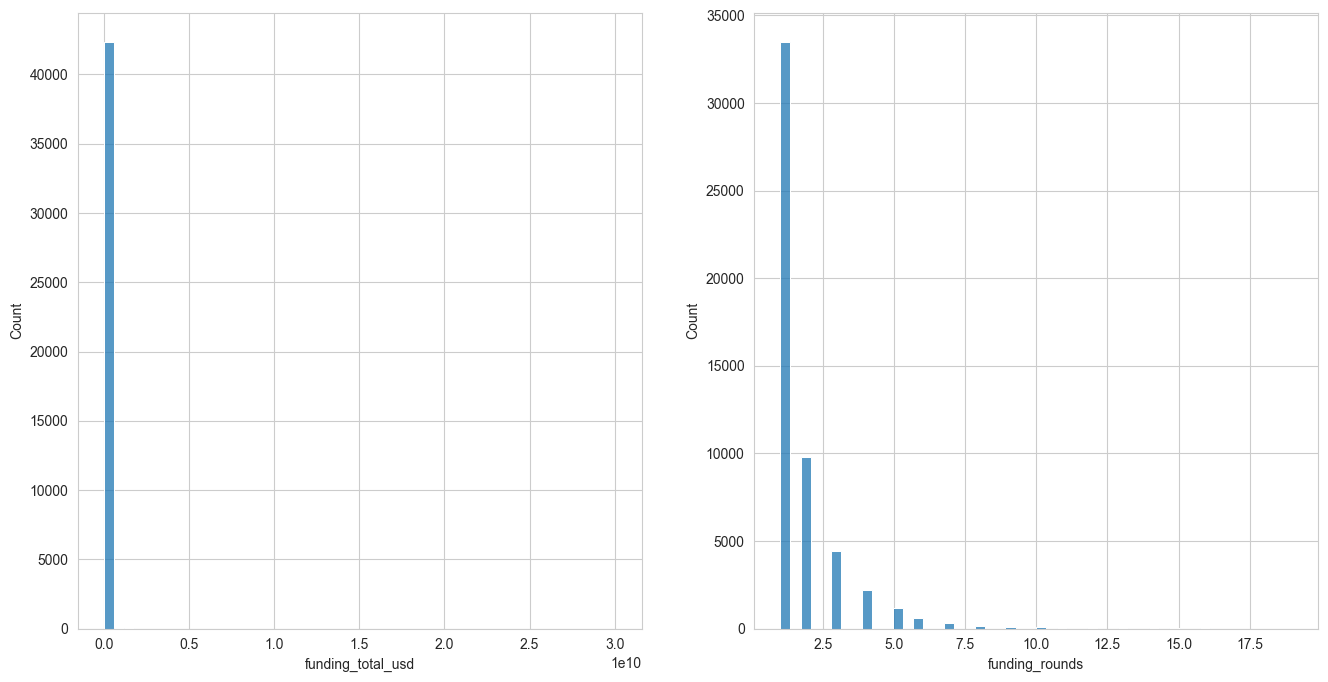

In [406]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Выводим гистограмму числовых значений
for i in range(len(num_col_names)):
    sns.histplot(data=df, x=num_col_names[i], bins=50, ax=axes[i])

plt.show()

Рассмотрим столбцы, которые у нас есть
- `name` — в данном столбце у нас всего один пропуск, но эта это никак не повлияет на обучение модели, оставим все как есть
- `category_list` — в данном столбце у нас отсутствует 4.7% данных. Всего там 44% уникальных значений. Скорее всего пропуски в данном столбце мы заполним модой
- `funding_total_usd` — в данном столбце у нас отсутствует 19.2% данных. Так же по гистограмме видно, что там присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `status` — в данном столбце у нас представлен целевой признак. 90% компаний все еще работают, в то время как 10% компаний закрылись
- `country_code`— в данном столбце у нас отсутствует 10.5% данных. Всего там 134 уникальных значения. Пропуски мы заполним, медианным значением.
- `state_code`— в данном столбце у нас отсутствует 13% данных. Всего там 300 уникальных значений. Пропуски мы заполним медианным значением, предварительно сгруппировав данные по `county_code`
- `region`— в данном столбце у нас отсутствует 12% данных. Всего там 1036 уникальных значений. Пропуски мы заполним модой, сгруппировав `state_code`
- `city` — в данном столбце у нас отсутствует 12% данных. Всего там 4477 уникальных значений. Пропуски мы заполним модой, сгруппировав `city`
- `funding_rounds`— в данном столбце у нас нет пропусков, однако присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `founded_at` — в данном столбце у нас нет пропусков и выбросов. Гистограмма выглядит так, потому что в ранние годы либо было сильно меньше стартапов, либо их регистрация не фиксировалась
- `first_funding_at` — в данном столбце у нас аналогично предыдущему
- `last_funding_at` — в данном столбце у нас все аналогично предыдущему
- `closed_at` — в данном столбце у нас отсутствует 90% данных, но этот столбец понадобится нам только для исследовательского анализа

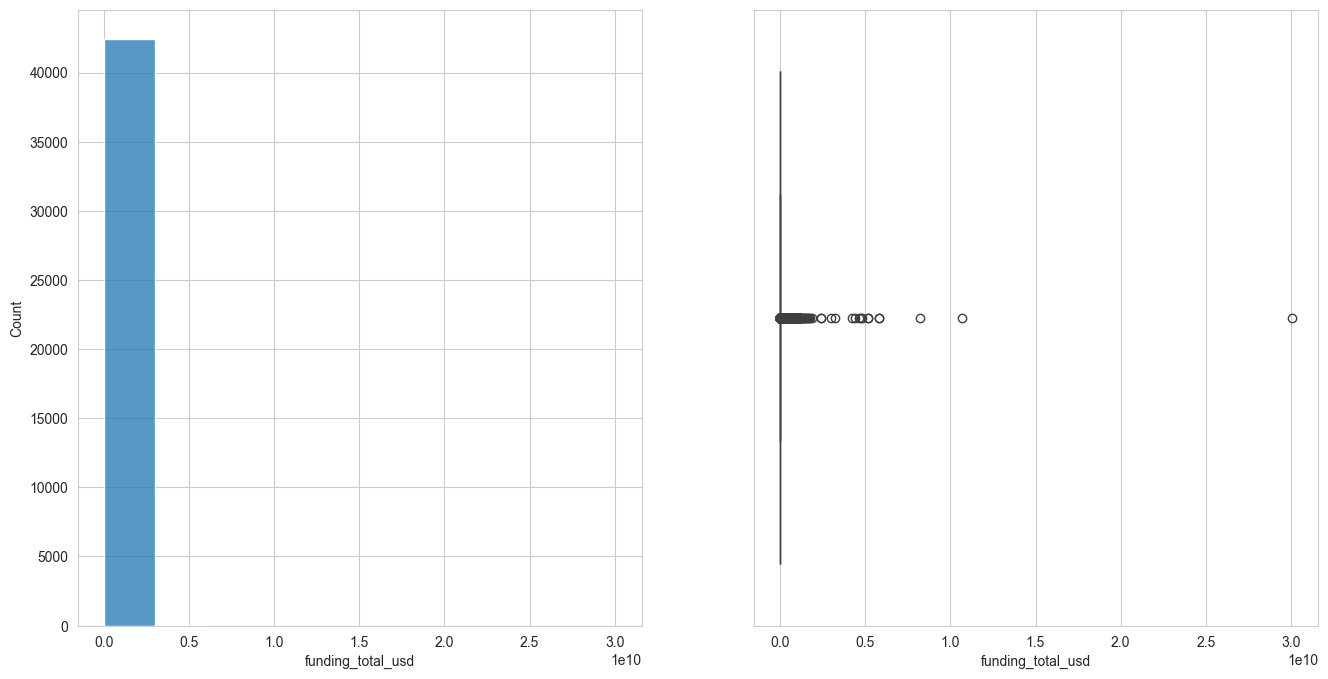

In [407]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(data=df, x='funding_total_usd', bins=10, ax=ax[0])
sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

Мы видим, что у нас присутствуют выбросы, которые вызваны даже если не вызваны ошибкой, то все равно помешают обучению модели. Остальные выбросы мы оставим, чтобы модель не обучалась в "идеальных" условиях. На первый взгляд, примерно 10-20 самых больших значений являются "критическими" выбросами. Посмотрим и удалим их

In [408]:
# Смотрим самые большие значение и количество раундов финансирования
df.sort_values(by=['funding_total_usd'], ascending=False)[['funding_total_usd', 'funding_rounds']]

,funding_total_usd,funding_rounds
39186,3.007950e+10,5
21241,1.066494e+10,1
4557,8.207450e+09,13
15976,5.820000e+09,6
36634,5.800000e+09,1
...,...,...
52499,NaN,3
52502,NaN,1
52507,NaN,1
52508,NaN,1


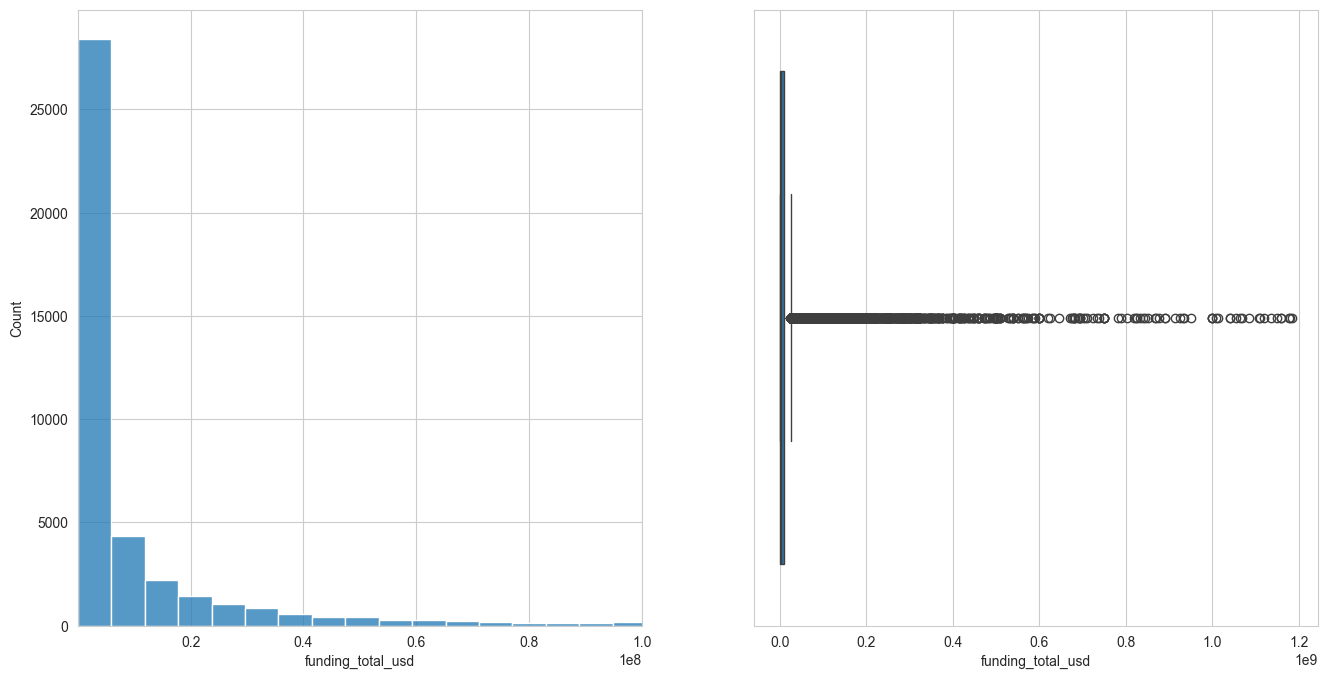

In [409]:
# Удаляем первые 30 самых больших значений
df = df.sort_values('funding_total_usd', ascending=False).iloc[30:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_xlim(1, 100000000)
sns.histplot(data=df, x='funding_total_usd', bins=200, ax=ax[0])

sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

In [410]:
# Смотрим уникальные значение кода страны
df['country_code'].unique()

array(['USA', 'IND', 'DEU', 'CHN', 'SWE', 'CAN', nan, 'GBR', 'ARE', 'HKG',
       'GRD', 'NLD', 'MYS', 'SGP', 'RUS', 'BRA', 'JPN', 'BMU', 'ESP',
       'NZL', 'IDN', 'DNK', 'LUX', 'CHE', 'MUS', 'FRA', 'NOR', 'ZAF',
       'ISR', 'TGO', 'AUS', 'BEL', 'MEX', 'IRL', 'TUR', 'NGA', 'FIN',
       'PHL', 'AUT', 'PAK', 'KOR', 'TWN', 'EGY', 'CZE', 'VNM', 'ITA',
       'POL', 'TAN', 'PRT', 'ARG', 'KEN', 'COL', 'THA', 'GIB', 'LTU',
       'MAF', 'ARM', 'CYM', 'PER', 'CHL', 'EST', 'GHA', 'KNA', 'PAN',
       'ISL', 'KWT', 'MNE', 'MLT', 'SVN', 'KAZ', 'URY', 'BGR', 'BAH',
       'TTO', 'HUN', 'LIE', 'ROM', 'UKR', 'GRC', 'LVA', 'CYP', 'JOR',
       'SVK', 'GGY', 'TUN', 'SEN', 'LBN', 'UGA', 'LAO', 'SOM', 'MAR',
       'BWA', 'IRN', 'HRV', 'PRI', 'SRB', 'JAM', 'BGD', 'NIC', 'MCO',
       'VEN', 'SAU', 'CRI', 'KHM', 'BHR', 'ECU', 'DZA', 'CMR', 'BLM',
       'SLV', 'MMR', 'ALB', 'DOM', 'AZE', 'NPL', 'BLZ', 'QAT', 'RWA',
       'GTM', 'UZB', 'GEO', 'BLR', 'MDA', 'SYC', 'ZWE', 'PRY', 'ZMB',
       'OMN', '

In [411]:
print(df['country_code'].isna().sum())
df['country_code'].value_counts()

5500


country_code
USA    29686
GBR     2925
CAN     1540
IND     1274
CHN     1233
       ...  
TGO        1
MAF        1
KAZ        1
MNE        1
JEY        1
Name: count, Length: 134, dtype: int64

In [412]:
# Посмотрим, какие данные в других столбцах для записей с пропусками в столбце country_code
df.loc[df['country_code'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
47338,ZhongAn,Insurance,931300000.0,operating,NaN,NaN,NaN,NaN,1,2013-01-01,2015-06-12,2015-06-12,NaT
31092,Open Environment Corporation,Computers|Software|Technology,870578950.0,closed,NaN,NaN,NaN,NaN,2,1992-01-01,1994-12-01,2001-01-01,2002-06-26
49067,Apollo Aviation Group,Banking|Finance|Investment Management,833000000.0,operating,NaN,NaN,NaN,NaN,1,2014-01-07,2015-10-07,2015-10-07,NaT
2954,Intime Retail,E-Commerce,692000000.0,operating,NaN,NaN,NaN,NaN,1,1998-01-01,2014-03-01,2014-03-01,NaT
29972,Magna Energy,Energy|Oil and Gas|Services,500000000.0,closed,NaN,NaN,NaN,NaN,1,2014-05-14,2015-06-22,2015-06-22,2016-08-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaT
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03
52420,Deutsche Startups,News|Startups,NaN,operating,NaN,NaN,NaN,NaN,1,2006-08-18,2007-04-08,2007-04-08,NaT


Мы видим, что данные, с пропуском в столбце `country_code`все еще валидны, поэтому нам нужно заполнить пропуски. Сделаем это, используя моду.

In [413]:
# Заполняем пропуски модой
df['country_code'] = df['country_code'].fillna(df['country_code'].mode()[0])

# Проверяем, остались ли у нас пропуски в данном столбце
df['country_code'].isna().sum()

0

In [414]:
pd.DataFrame(
    {'missing_total': df.isna().sum(),
     'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),
     'unique_count': df.nunique(),
     'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,1,0.0,52485,100.0
category_list,2465,4.7,22092,42.1
funding_total_usd,10069,19.2,15521,29.6
status,0,0.0,2,0.0
country_code,0,0.0,134,0.3
state_code,6759,12.9,300,0.6
region,6355,12.1,1036,2.0
city,6355,12.1,4477,8.5
funding_rounds,0,0.0,19,0.0
founded_at,0,0.0,5398,10.3


In [415]:
def fill_missing_values(dataframe):
    """
    Заполняет пропущенные значения в DataFrame для заданных столбцов с учетом их типа и иерархии.
    Returns:
        pd.DataFrame:
            Модифицированный DataFrame с заполненными пропусками:
            - Для `category_list` и `country_code` — мода (наиболее частое значение).
            - Для `funding_total_usd` — медиана (устойчивая к выбросам).
            - Для `state_code`, `region`, `city` — мода в рамках родительской категории
              (например, `state_code` заполняется по `country_code`). При отсутствии данных
              используется код/название родительской категории .
    """

    # Заполняем пропуски в столбце category_list модой
    dataframe['category_list'] = dataframe['category_list'].fillna(dataframe['category_list'].mode()[0])

    # Заполняем пропуски в столбце funding_total_usd медианой
    dataframe['funding_total_usd'] = dataframe['funding_total_usd'].fillna(dataframe['funding_total_usd'].median())

    # Заполняем пропуски в столбце country_code модой
    dataframe['country_code'] = dataframe['country_code'].fillna(dataframe['country_code'].mode()[0])

    # Заполняем пропуски в столбце state_code модой, сгруппировав данные по country_code
    for code in dataframe['country_code'].unique():
        try:
            # заполняем самым частым значением для определенного кода страны
            dataframe.loc[dataframe['country_code'] == code, 'state_code'] = dataframe.loc[
                dataframe['country_code'] == code, 'state_code'].fillna(
                dataframe.loc[dataframe['country_code'] == code, 'state_code'].mode()[0])
        except:
            # заполняем значением кода страны
            dataframe.loc[dataframe['country_code'] == code, 'state_code'] = dataframe.loc[
                dataframe['country_code'] == code, 'state_code'].fillna(code)

    # Заполняем пропуски в столбце region модой, сгруппировав данные по state_code
    for code in dataframe['state_code'].unique():
        try:
            # заполняем самым частым значением для определенного кода штата
            dataframe.loc[dataframe['state_code'] == code, 'region'] = dataframe.loc[
                dataframe['state_code'] == code, 'region'].fillna(
                dataframe.loc[dataframe['state_code'] == code, 'region'].mode()[0])
        except:
            # заполняем значением кода штата
            dataframe.loc[dataframe['state_code'] == code, 'region'] = dataframe.loc[
                dataframe['state_code'] == code, 'region'].fillna(code)

    # Заполняем пропуски в столбце city модой, сгруппировав данные по region
    for region in dataframe['region'].unique():
        try:
            # Заполняем самым частым значением для определенного региона
            dataframe.loc[dataframe['region'] == region, 'city'] = dataframe.loc[
                dataframe['region'] == region, 'city'].fillna(
                dataframe.loc[dataframe['region'] == region, 'city'].mode()[0])
        except:
            # Заполняем значением названием региона
            dataframe.loc[dataframe['region'] == region, 'city'] = dataframe.loc[
                dataframe['region'] == region, 'city'].fillna(region)

    return dataframe

In [416]:
df = fill_missing_values(df)

In [417]:
pd.DataFrame(
    {'missing_total': df.isna().sum(),
     'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),
     'unique_count': df.nunique(),
     'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,1,0.0,52485,100.0
category_list,0,0.0,22092,42.1
funding_total_usd,0,0.0,15521,29.6
status,0,0.0,2,0.0
country_code,0,0.0,134,0.3
state_code,0,0.0,319,0.6
region,0,0.0,1044,2.0
city,0,0.0,4485,8.5
funding_rounds,0,0.0,19,0.0
founded_at,0,0.0,5398,10.3


Перед обработкой пропусков, мы удалили 30 самых больших значений в столбце `funding_total_usd`, потому что они бы сильно повлияли на обучение модели. Остальные выбросы мы оставили, чтобы модель не обучалась в "идеальных условиях"

Мы создали функцию для заполнения пропусков. Все пропуски были заполнены, основываясь на моде. Заполняли мы их, предварительно сгруппировав данные по "предыдущему столбцу"

### Предобработка в тестовом датасете

Ранее мы создали функцию для предобработки, поэтому сейчас нам достаточно просто применить ее к тестовому датасету. Так как это тестовый датасет, то мы не можем удалять все выбросы

In [418]:
pd.DataFrame(
    {'missing_total': test_df.isna().sum(),
     'missing_percent': round(test_df.isna().sum() / test_df.shape[0] * 100, 1),
     'unique_count': test_df.nunique(),
     'unique_percent': round(test_df.nunique() / test_df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,0,0.0,13125,100.0
category_list,591,4.5,6206,47.3
funding_total_usd,2578,19.6,4549,34.7
country_code,1382,10.5,96,0.7
state_code,1695,12.9,235,1.8
region,1589,12.1,688,5.2
city,1587,12.1,2117,16.1
funding_rounds,0,0.0,15,0.1
first_funding_at,0,0.0,3299,25.1
last_funding_at,0,0.0,3021,23.0


In [419]:
test_df = fill_missing_values(test_df)

In [420]:
pd.DataFrame(
    {'missing_total': test_df.isna().sum(),
     'missing_percent': round(test_df.isna().sum() / test_df.shape[0] * 100, 1),
     'unique_count': test_df.nunique(),
     'unique_percent': round(test_df.nunique() / test_df.shape[0] * 100, 1),
     }
)

,missing_total,missing_percent,unique_count,unique_percent
name,0,0.0,13125,100.0
category_list,0,0.0,6206,47.3
funding_total_usd,0,0.0,4549,34.7
country_code,0,0.0,96,0.7
state_code,0,0.0,243,1.9
region,0,0.0,697,5.3
city,0,0.0,2125,16.2
funding_rounds,0,0.0,15,0.1
first_funding_at,0,0.0,3299,25.1
last_funding_at,0,0.0,3021,23.0


### Вывод:

Во время предобработки данных мы создали функцию для удаления пропусков.

В тренировочным датасете мы удалили 30 самых больших значений. Остальные выбросы мы оставили.

В тестовом датасете мы обработали пропуски, используя функцию.

## Feature engineering

Проведем генерацию признаков: извлечем из дат год, месяц, и день. Так же сократим количество уникальных значений в категориальных столбцах: заменим значения, которые фигурируют мало раз на `other`. Для этого нам надо будет определить, какое значение считается "малым"

In [421]:
df['category_list'].value_counts()

category_list
Software                                                5672
Biotechnology                                           2904
E-Commerce                                              1061
Mobile                                                   920
Clean Technology                                         891
                                                        ... 
Recycling|Service Providers|Services                       1
Financial Services|Gift Card                               1
Consulting|Databases|Market Research                       1
Advertising|Content|Design|E-Commerce|SEO|Web Design       1
Information Services|Services|Software                     1
Name: count, Length: 22092, dtype: int64

In [422]:
np.savetxt('categories.txt', df['category_list'].unique(), delimiter=',', fmt='%s')

In [423]:
df['category_list'].nunique()

22092

In [424]:
# Словарь для категорий
manual_mapping = {
    # E-Commerce
    'e-commerce': 'E-Commerce',
    'marketplaces': 'E-Commerce',
    'payments': 'E-Commerce',
    'social commerce': 'E-Commerce',
    'mobile commerce': 'E-Commerce',
    'online shopping': 'E-Commerce',
    'retail technology': 'E-Commerce',
    'e-commerce platforms': 'E-Commerce',
    'logistics': 'E-Commerce',
    'shipping': 'E-Commerce',

    # Healthcare
    'health care': 'Healthcare',
    'medical devices': 'Healthcare',
    'mhealth': 'Healthcare',
    'pharmaceuticals': 'Healthcare',
    'medical': 'Healthcare',
    'hospitals': 'Healthcare',

    # Technology
    'technology': 'Technology',
    'cloud computing': 'Technology',
    'artificial intelligence': 'Technology',
    'machine learning': 'Technology',
    'enterprise software': 'Technology',
    'data security': 'Technology',
    'cyber security': 'Technology',
    'network security': 'Technology',
    'mobile': 'Technology',
    'saas': 'Technology',
    'software': 'Technology',
    'internet of things': 'Technology',
    'wearables': 'Technology',
    'image recognition': 'Technology',

    # Finance
    'finance': 'Finance',
    'fintech': 'Finance',
    'investment management': 'Finance',
    'wealth management': 'Finance',
    'financial services': 'Finance',
    'payments': 'Finance',

    # Education
    'education': 'Education',
    'edtech': 'Education',
    'online education': 'Education',
    'educational games': 'Education',

    # Marketing & Advertising
    'advertising': 'Marketing',
    'social media marketing': 'Marketing',
    'brand marketing': 'Marketing',
    'digital media': 'Marketing',
    'content': 'Marketing',

    # Logistics & Delivery
    'logistics': 'Logistics',
    'shipping': 'Logistics',
    'delivery': 'Logistics',

    # Security
    'security': 'Security',
    'data security': 'Security',
    'network security': 'Security',
    'cyber security': 'Security',

    # Media & Entertainment
    'media': 'Media',
    'entertainment': 'Media',
    'video streaming': 'Media',
    'music': 'Media',
    'games': 'Media',

    # Real Estate
    'real estate': 'Real Estate',
    'property management': 'Real Estate',

    # Travel & Hospitality
    'travel & tourism': 'Travel',
    'hospitality': 'Travel',
    'restaurants': 'Travel',

    # Manufacturing & Industrial
    'manufacturing': 'Manufacturing',
    'industrial': 'Manufacturing',

    # Energy
    'energy management': 'Energy',
    'renewable energies': 'Energy',

    # Agriculture
    'agriculture': 'Agriculture',

    # Automotive
    'cars': 'Automotive',
    'automotive': 'Automotive',

    # Nonprofits & Social
    'nonprofits': 'Nonprofits',
    'social media': 'Nonprofits',

    # Default rule
    'other': 'Other'
}

In [425]:
# Функция для извлечения года, месяца, дня
def extrat_date(col) -> tuple:
    year = col.year
    month = col.month
    day = col.day

    return year, month, day


# Функция для замены значений
def replace_rare_categories(df, thresholds):
    """
    Заменяет категории в столбцах на 'other', если их частота ниже порога.

    Аргументы:
    - df: pandas.DataFrame (датафрейм)
    - thresholds: dict (словарь в формате {столбец: порог})
    """
    for column, threshold in thresholds.items():
        # Подсчет частоты категорий
        value_counts = df[column].value_counts()

        # Создание маски для замены
        mask = df[column].map(value_counts) < threshold

        # Замена значений
        df[column] = df[column].mask(mask, 'other')

    return df


# Функция для приведения категории к глобальной категории
def map_to_global_category(category_str):
    # Разбиваем строку на подкатегории, удаляем пробелы и приводим к нижнему регистру
    subcategories = [subcat.strip().lower() for subcat in category_str.split('|')]
    # Проверяем каждую подкатегорию в словаре
    for subcat in subcategories:
        if subcat in manual_mapping:
            return manual_mapping[subcat]
    # Если не найдено, возвращаем первую подкатегорию или 'Other'
    return subcategories[0] if subcategories else 'Other'

### Feature engineering в тренировочном датафрейме

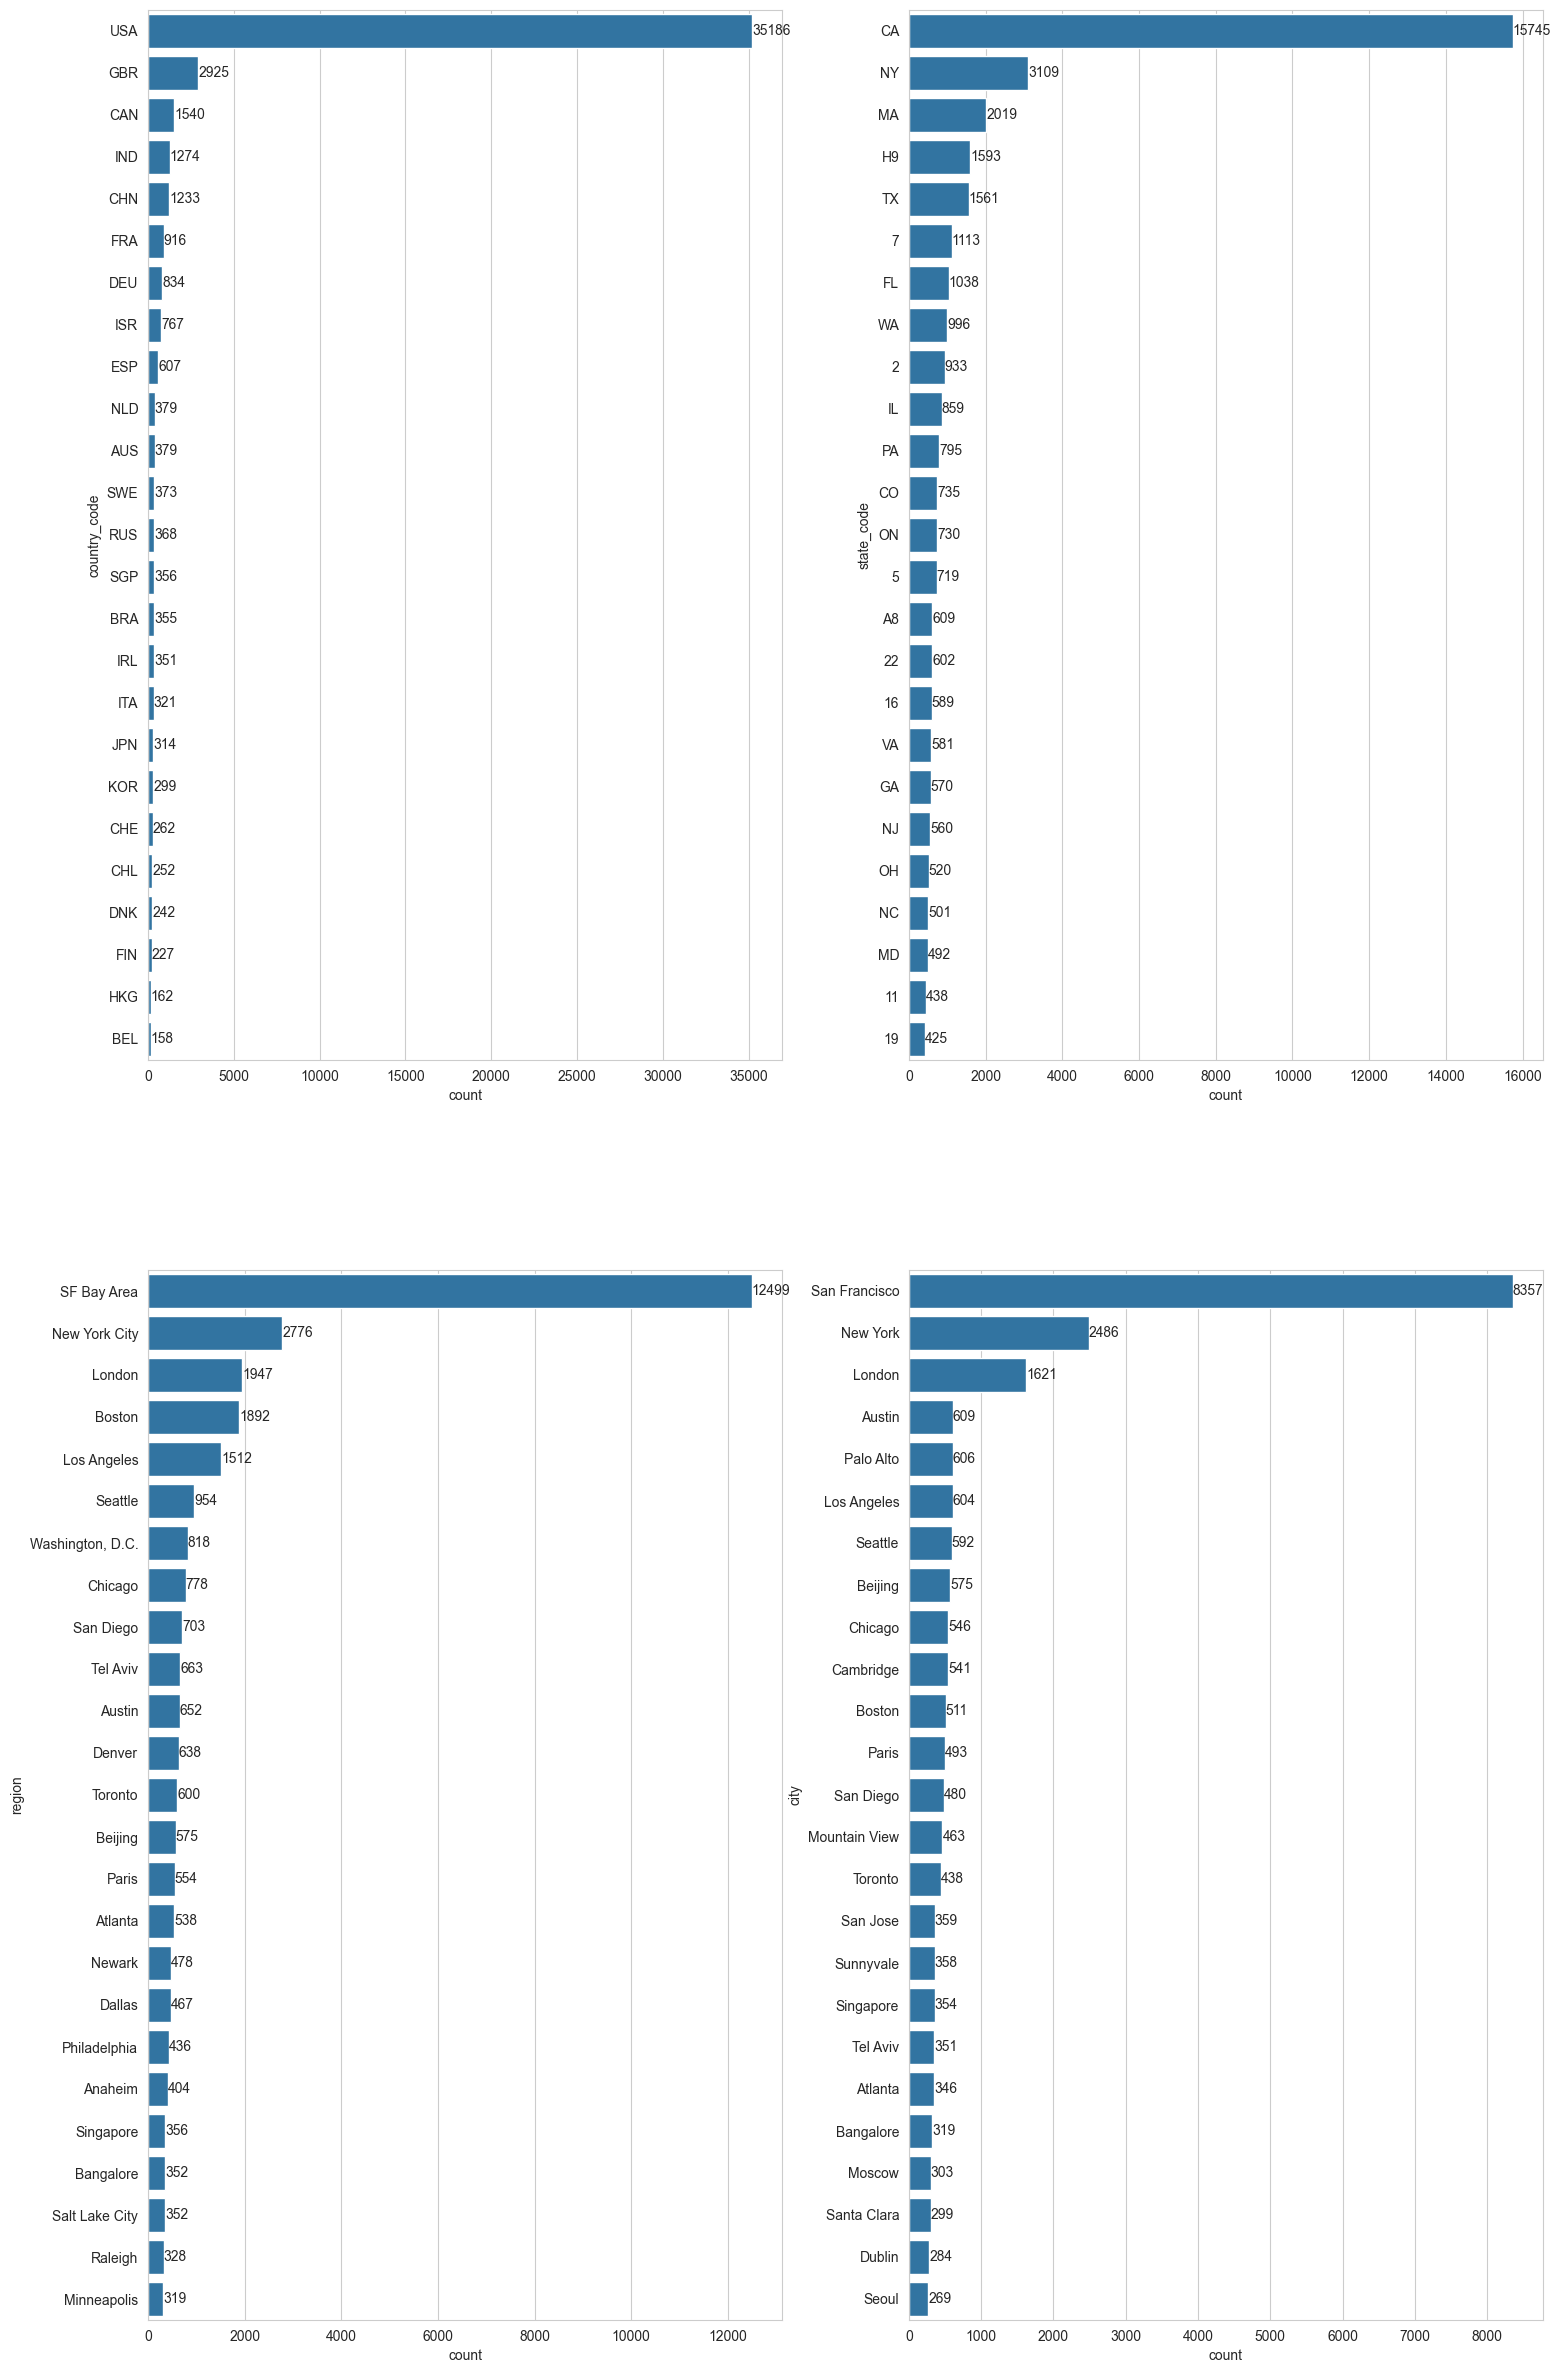

In [426]:
# Выведем горизонтальную столбчатую диаграмму для количества значений в каждом столбце
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 30))

sns.barplot(x=df[cat_col_names[1]].value_counts().head(25),
            y=df[cat_col_names[1]].value_counts().index[:25],
            ax=axes[0, 0])
axes[0, 0].bar_label(axes[0, 0].containers[0])

sns.barplot(x=df[cat_col_names[2]].value_counts().head(25),
            y=df[cat_col_names[2]].value_counts().index[:25],
            ax=axes[0, 1])
axes[0, 1].bar_label(axes[0, 1].containers[0])

sns.barplot(x=df[cat_col_names[3]].value_counts().head(25),
            y=df[cat_col_names[3]].value_counts().index[:25],
            ax=axes[1, 0])
axes[1, 0].bar_label(axes[1, 0].containers[0])

sns.barplot(x=df[cat_col_names[4]].value_counts().head(25),
            y=df[cat_col_names[4]].value_counts().index[:25],
            ax=axes[1, 1])
axes[1, 1].bar_label(axes[1, 1].containers[0])

plt.show()

Определим пороговые значения для каждого столбца, ниже которых мы будем заменять значения на `other`:
- `category_list` — 400
- `country_code` — 600
- `state_code` — 700
- `region` — 700
- `city` — 400

In [427]:
# Определяем пороги для каждого столбца
thresholds = {
    # 'category_list': 50,
    'country_code': 50,
    'state_code': 50,
    'region': 50,
    'city': 50
}

# Заменяем редкие значения
df_processed = replace_rare_categories(df.copy(), thresholds)

# Сокращаем количество категорий
df_processed['global_category'] = df['category_list'].apply(map_to_global_category)

# Разбиваем на год, месяц, день столбец first_funding_at
df_processed[['first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day']] = df_processed[
    'first_funding_at'].apply(extrat_date).apply(pd.Series)

# Разбиваем на год, месяц, день столбец last_funding_at
df_processed[['last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day']] = df_processed[
    'last_funding_at'].apply(extrat_date).apply(pd.Series)

# Избавляемся от ненужных столбцов
df_processed = df_processed.drop(['name', 'category_list',
                                  'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'],
                                 axis=1)


In [428]:
# Выводим датасет после инженеринга
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
20259,1.185585e+09,operating,USA,CA,CA - Other,other,8,Technology,2012,5,1,2015,5,29
45940,1.180000e+09,operating,USA,WA,Seattle,other,2,cable,2012,11,14,2015,5,21
51180,1.176830e+09,operating,IND,other,other,other,7,Automotive,2011,4,21,2015,11,17
50610,1.159803e+09,operating,USA,WA,Seattle,Seattle,4,Healthcare,2013,12,3,2015,7,14
8051,1.158040e+09,operating,USA,CA,SF Bay Area,San Mateo,14,clean technology,2006,9,15,2015,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,2.000000e+06,operating,CHN,22,Beijing,Beijing,3,Finance,2011,12,1,2015,9,22
52502,2.000000e+06,operating,BRA,27,BRA - Other,other,1,E-Commerce,2008,1,1,2008,1,1
52507,2.000000e+06,operating,USA,MD,Baltimore,other,1,Healthcare,2011,1,20,2011,1,20
52508,2.000000e+06,operating,HKG,HKG,Hong Kong,Hong Kong,1,Technology,2015,11,20,2015,11,20


### Feature engineering в тестовом датасете

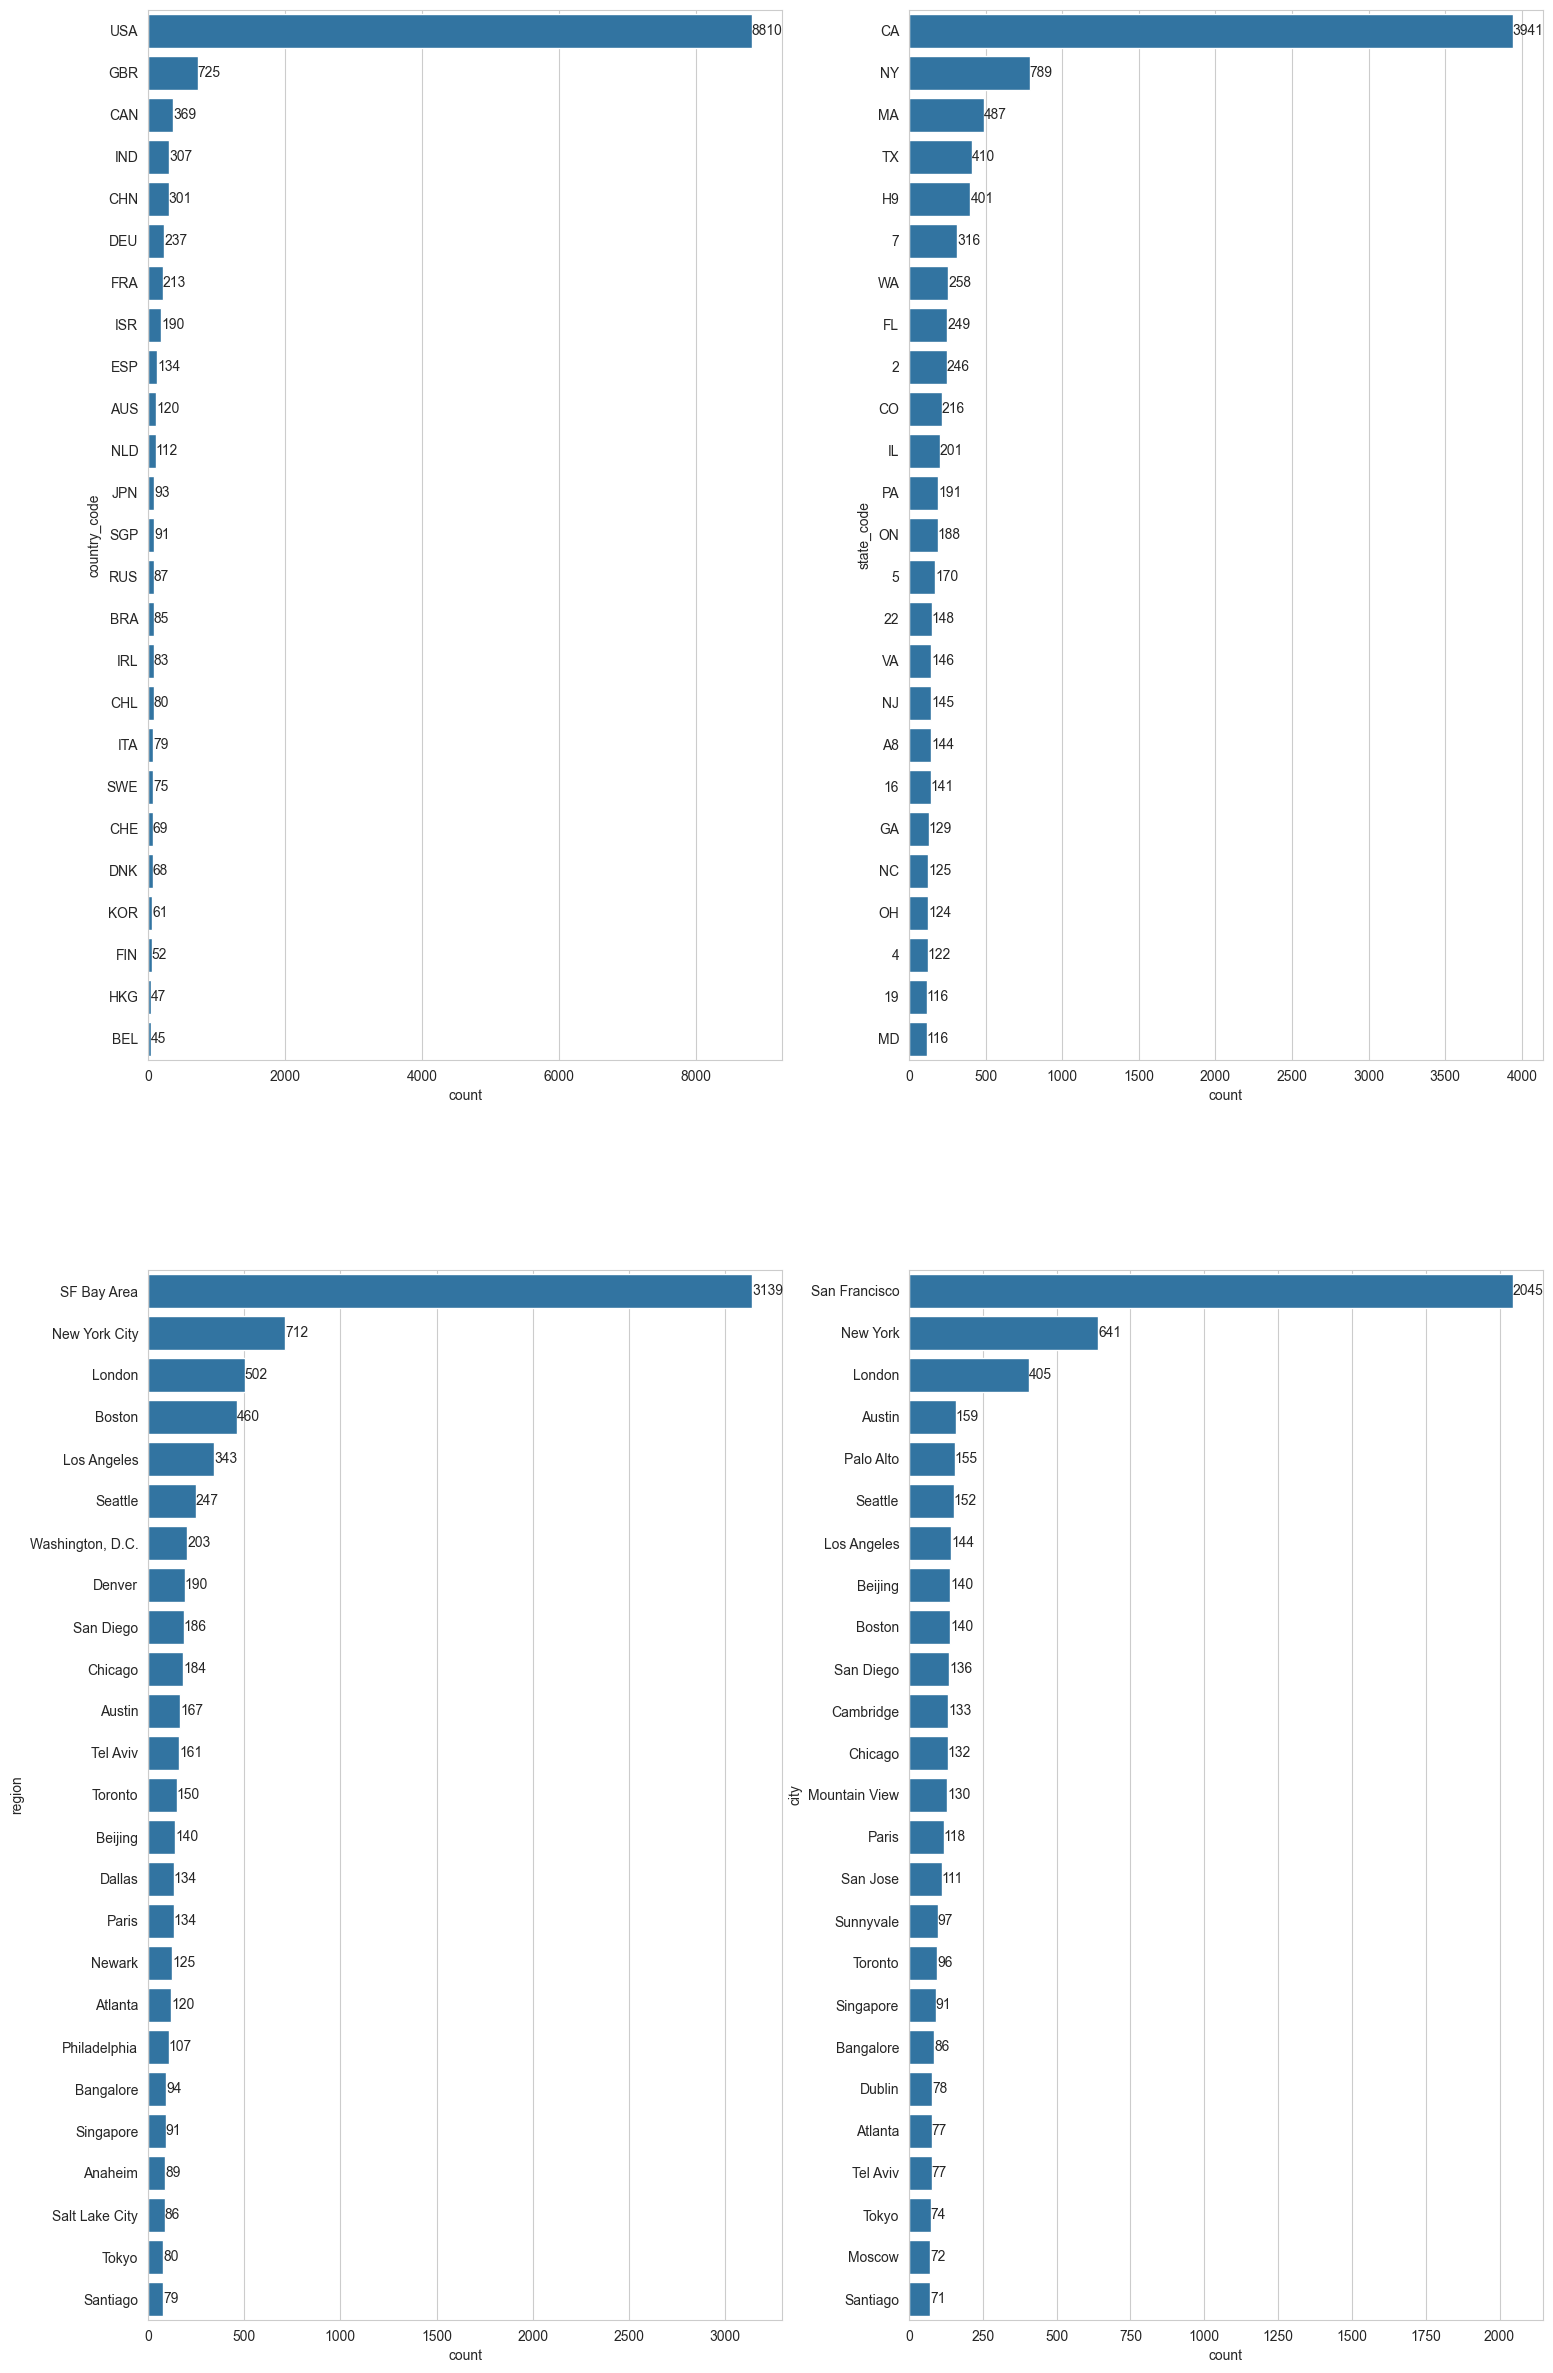

In [429]:
# Выведем горизонтальную столбчатую диаграмму для количества значений в каждом столбце
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 30))

sns.barplot(x=test_df[cat_col_names[1]].value_counts().head(25),
            y=test_df[cat_col_names[1]].value_counts().index[:25],
            ax=axes[0, 0])
axes[0, 0].bar_label(axes[0, 0].containers[0])

sns.barplot(x=test_df[cat_col_names[2]].value_counts().head(25),
            y=test_df[cat_col_names[2]].value_counts().index[:25],
            ax=axes[0, 1])
axes[0, 1].bar_label(axes[0, 1].containers[0])

sns.barplot(x=test_df[cat_col_names[3]].value_counts().head(25),
            y=test_df[cat_col_names[3]].value_counts().index[:25],
            ax=axes[1, 0])
axes[1, 0].bar_label(axes[1, 0].containers[0])

sns.barplot(x=test_df[cat_col_names[4]].value_counts().head(25),
            y=test_df[cat_col_names[4]].value_counts().index[:25],
            ax=axes[1, 1])
axes[1, 1].bar_label(axes[1, 1].containers[0])

plt.show()

In [430]:
# Определяем пороги для каждого столбца
thresholds = {
    # 'category_list': 10,
    'country_code': 100,
    'state_code': 100,
    'region': 100,
    'city': 100
}

# Заменяем редкие значения
test_df_processed = replace_rare_categories(test_df.copy(), thresholds)

# Сокращаем количество категорий
test_df_processed['global_category'] = df['category_list'].apply(map_to_global_category)

# Разбиваем на год, месяц, день столбец first_funding_at
test_df_processed[['first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day']] = test_df_processed[
    'first_funding_at'].apply(extrat_date).apply(pd.Series)

# Разбиваем на год, месяц, день столбец last_funding_at
test_df_processed[['last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day']] = test_df_processed[
    'last_funding_at'].apply(extrat_date).apply(pd.Series)

# Избавляемся от ненужных столбцов
test_df_processed = test_df_processed.drop(['name', 'first_funding_at', 'last_funding_at', 'lifetime', 'category_list'], axis=1)


In [431]:
test_df_processed

,funding_total_usd,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
0,2819200.0,other,other,other,other,1,Travel,2009,7,1,2009,7,1
1,2000000.0,USA,TN,other,other,1,Manufacturing,2010,7,28,2010,7,28
2,428257.0,other,other,other,other,2,biotechnology,2014,5,15,2014,9,18
3,34700000.0,USA,CA,San Diego,San Diego,4,Healthcare,2005,1,1,2010,4,20
4,4530000.0,CAN,ON,other,other,1,Manufacturing,2007,5,8,2007,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,28000.0,USA,CA,SF Bay Area,other,1,Finance,2012,7,1,2012,7,1
13121,2000000.0,USA,CA,SF Bay Area,Mountain View,1,Technology,2013,10,1,2013,10,1
13122,5600000.0,USA,WA,Seattle,Seattle,3,hardware + software,2008,9,1,2011,6,28
13123,150000.0,USA,NY,New York City,New York,2,E-Commerce,2014,9,27,2014,11,4


### Вывод

Мы написали 2 функции:
1. Функция, которая выделяет год, месяц, день из столбцов `first_funding_at`, `last_funding_at`. Столбец `founded_at` `closed_at` мы удалили из тренировочного датасета, так как их нет в тестовом датасете.
2. Функция, которая заменяет "малые" значения в категориальных столбцах на значение `other`. Пороги для замены мы оперделили, используя столбчатую диаграмму

Мы создали 2 новых датасета: `df_processed` и `test_df_processed`. В них мы избавились от лишних столбцов, которые не участвуют в обучении и предсказании модели, а так же применили к ним наши функции.

## Исследовательский анализ данных

Посмотрим на отличия между двумя группами: закрывшиеся и работающие стартапы

## Корреляционный анализ данных

In [432]:
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,first_funding_at_month,first_funding_at_day,last_funding_at_year,last_funding_at_month,last_funding_at_day
20259,1.185585e+09,operating,USA,CA,CA - Other,other,8,Technology,2012,5,1,2015,5,29
45940,1.180000e+09,operating,USA,WA,Seattle,other,2,cable,2012,11,14,2015,5,21
51180,1.176830e+09,operating,IND,other,other,other,7,Automotive,2011,4,21,2015,11,17
50610,1.159803e+09,operating,USA,WA,Seattle,Seattle,4,Healthcare,2013,12,3,2015,7,14
8051,1.158040e+09,operating,USA,CA,SF Bay Area,San Mateo,14,clean technology,2006,9,15,2015,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52499,2.000000e+06,operating,CHN,22,Beijing,Beijing,3,Finance,2011,12,1,2015,9,22
52502,2.000000e+06,operating,BRA,27,BRA - Other,other,1,E-Commerce,2008,1,1,2008,1,1
52507,2.000000e+06,operating,USA,MD,Baltimore,other,1,Healthcare,2011,1,20,2011,1,20
52508,2.000000e+06,operating,HKG,HKG,Hong Kong,Hong Kong,1,Technology,2015,11,20,2015,11,20


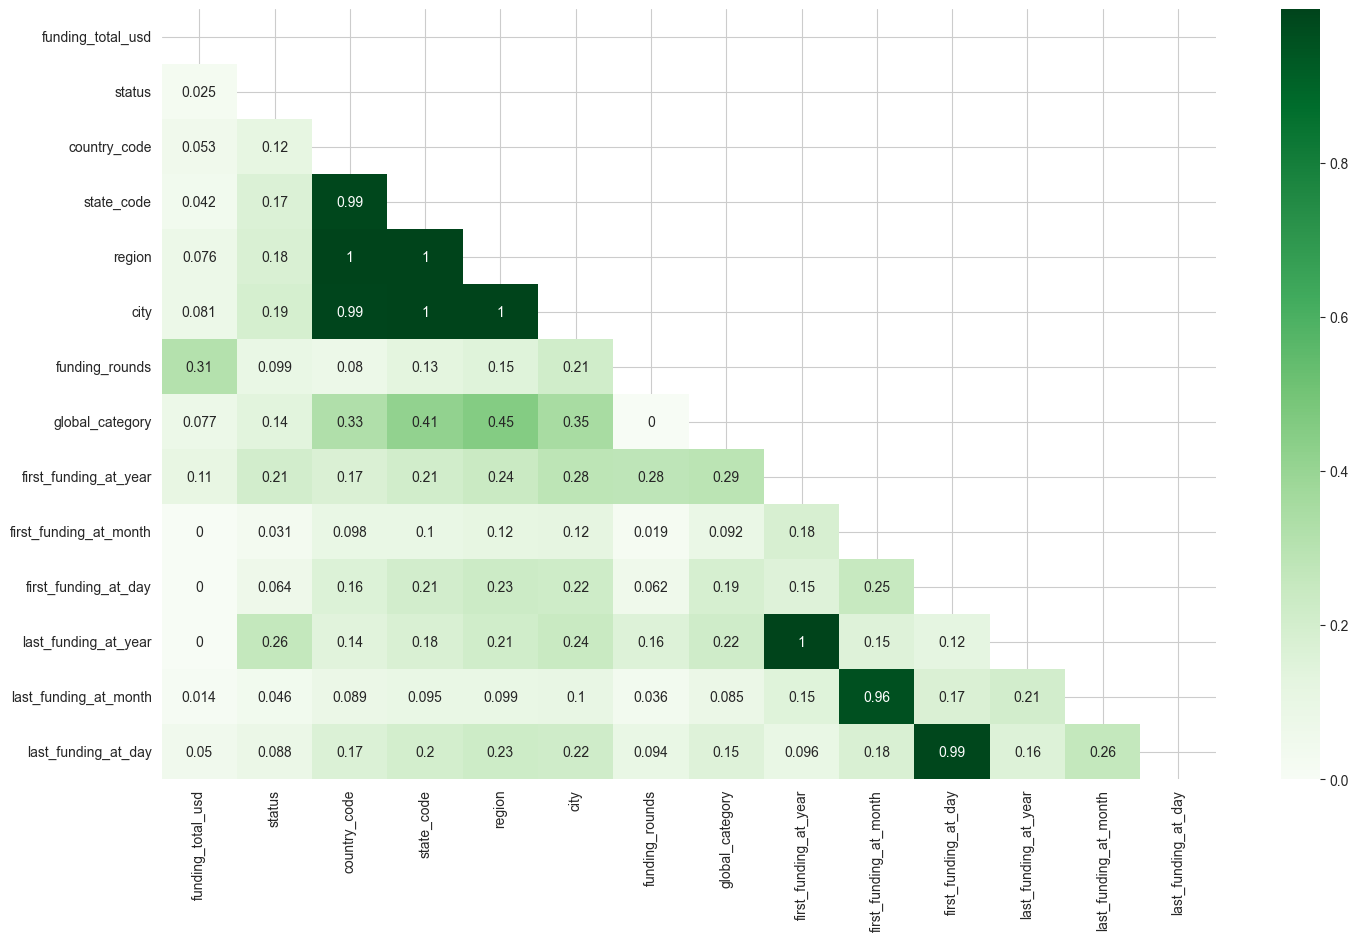

In [433]:
plt.figure(figsize=(17, 10))

ic = ['funding_total_usd', 'funding_rounds']
# 'first_funding_at_year', 'first_funding_at_month', 'first_funding_at_day',
# 'last_funding_at_year', 'last_funding_at_month', 'last_funding_at_day']
sns.heatmap(
    df_processed.phik_matrix(interval_cols=ic),
    annot=True, cmap='Greens',
    mask=(np.triu(
        np.ones_like(df_processed.phik_matrix(interval_cols=ic), dtype=bool)))
)

plt.show()

Мы видим, что у целевого признака невероятно маленькая корреляция с признаками `first_funding_at_month`, `first_funding_at_day`, `last_funding_at_month`, `last_funding_at_day`. Удалим их

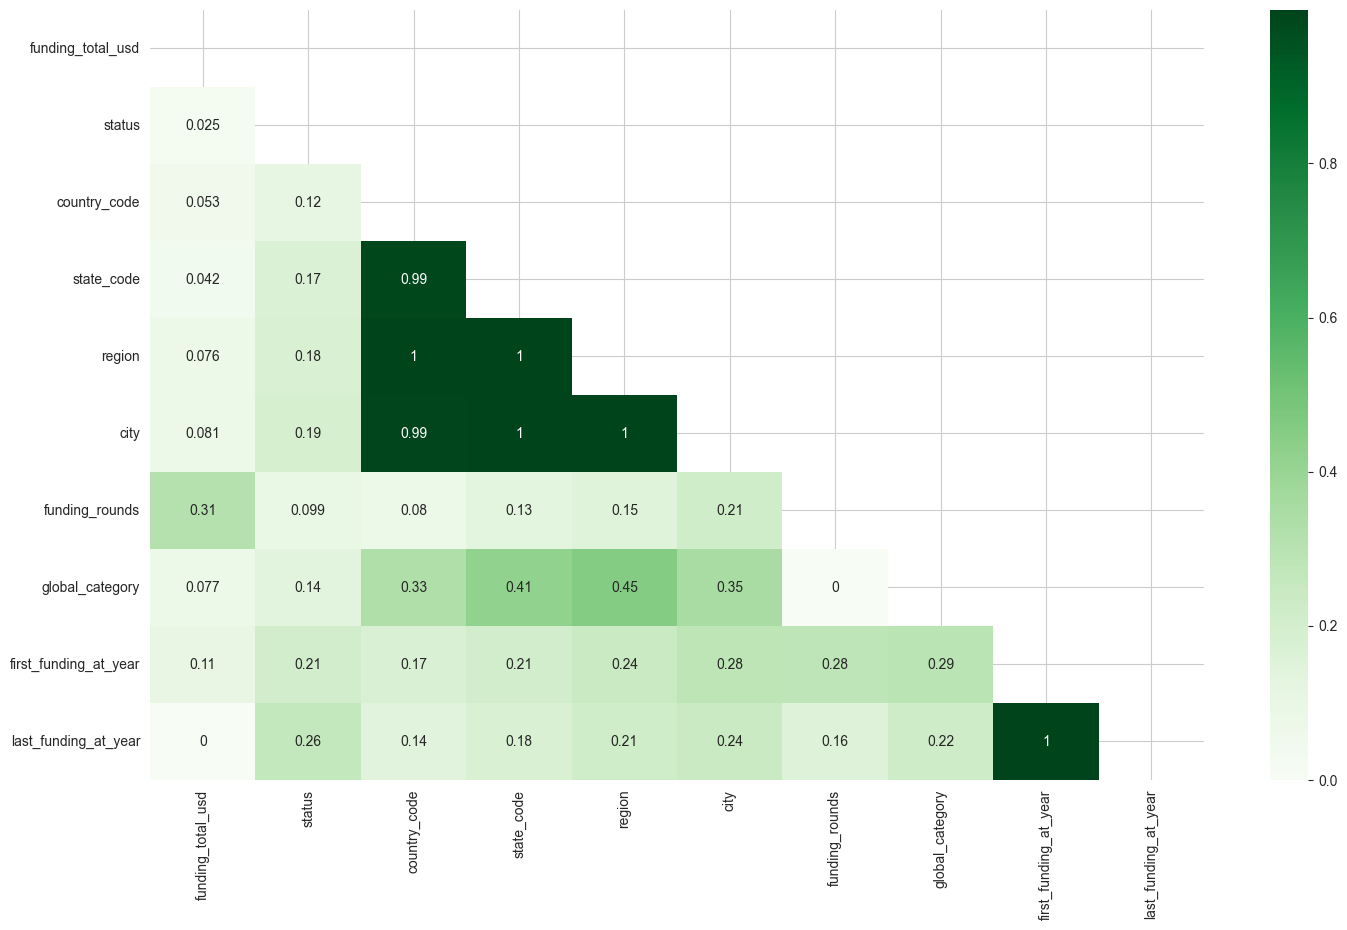

In [434]:
plt.figure(figsize=(17, 10))

# Удаляем ненужные столбцы
df_processed = df_processed.drop(
    ['first_funding_at_day', 'first_funding_at_month', 'last_funding_at_day', 'last_funding_at_month'], axis=1)
test_df_processed = test_df_processed.drop(
    ['first_funding_at_day', 'first_funding_at_month', 'last_funding_at_day', 'last_funding_at_month'], axis=1)

ic = ['funding_total_usd', 'funding_rounds']
sns.heatmap(
    df_processed.phik_matrix(
        interval_cols=ic),
    annot=True, cmap='Greens',
    mask=(np.triu(
        np.ones_like(df_processed.phik_matrix(interval_cols=ic), dtype=bool)))
)

plt.show()

Мы видим, у целевого признака `status` небольшая корреляция со всеми признаками. Наибольшая корреляция у него с годом первого и последнего спонсирования. Мы так же можем наблюдать мультиколлинеарность между всеми "географическими" столбцами, и `first_founded_at_year` вместе с `last_founded_at_year`. Однако это не помешает обучению модели, так что оставим все как есть


### Вывод:

Целовой признак не имеет высокой корреляции ни с одним из признаков. Столбцы `first_funding_at_month`, `first_funding_at_day`, `last_funding_at_month`, `last_funding_at_day` мы удалили, так как корреляция с целевым была ниже 0.1. Некоторые столбцы мультиколлинеарны, однако это не является для нас проблемой, так как мультиколлинеарности с целевым признаком нет.

## Создание пайплайна

Соберем пайплайн для кодирования числовых и категориальных значений. Потом создадим сетку параметров для нашего пайплайна, и посмотрим на метрику, используя RandomizedSearchCV

In [435]:
df_processed

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,last_funding_at_year
20259,1.185585e+09,operating,USA,CA,CA - Other,other,8,Technology,2012,2015
45940,1.180000e+09,operating,USA,WA,Seattle,other,2,cable,2012,2015
51180,1.176830e+09,operating,IND,other,other,other,7,Automotive,2011,2015
50610,1.159803e+09,operating,USA,WA,Seattle,Seattle,4,Healthcare,2013,2015
8051,1.158040e+09,operating,USA,CA,SF Bay Area,San Mateo,14,clean technology,2006,2015
...,...,...,...,...,...,...,...,...,...,...
52499,2.000000e+06,operating,CHN,22,Beijing,Beijing,3,Finance,2011,2015
52502,2.000000e+06,operating,BRA,27,BRA - Other,other,1,E-Commerce,2008,2008
52507,2.000000e+06,operating,USA,MD,Baltimore,other,1,Healthcare,2011,2011
52508,2.000000e+06,operating,HKG,HKG,Hong Kong,Hong Kong,1,Technology,2015,2015


In [436]:
# Определяем числовые и категориальные столбцы
num_col_names = ['funding_total_usd', 'funding_rounds', 'first_funding_at_year', 'last_funding_at_year']
cat_col_names = ['global_category', 'country_code', 'state_code', 'region', 'city']

# Пайплайн для числовых значений
num_pipeline = Pipeline([
    (
        'ImputerBeforeScaler',
        SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    ),
    (
        'num',
        StandardScaler()
    )
])

# Пайплайн для категориальных значений
ohe_pipeline = Pipeline([
    (
        'ImputerBeforeOhe',
        SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    ),
    (
        'OneHotEncoder',
        OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    ),
    (
        'ImputerAfterOhe',
        SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    )
])

# Собираем в один пайплайн по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_col_names),
        ('ohe', ohe_pipeline, cat_col_names),
    ],
    remainder='passthrough',
)

# Собираем все в конечный пайплайн
final_pipeline = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DummyClassifier(strategy='median')),
    ]
)

In [437]:
param_grid = [
    # Сетка параметров для логистической регрессии
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10, 100],
        'model__penalty': ['l2', 'none'],
        'model__max_iter': range(10, 1000),
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для метода опорных векторов
    {
        'model': [SVC(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10, 100],
        'model__degree': range(1, 11),
        'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для метода ближайших соседей
    {
        'model': [KNeighborsClassifier(n_jobs=-1)],
        'model__n_neighbors': range(3, 21),
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Стека параметров для дерева решений
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 50),
        'model__min_samples_split': range(2, 50),
        'model__min_samples_leaf': range(2, 50),
        'model__class_weight': ['balanced'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
        # 'select_k_best__k': range(1, X_train.shape[1] + 1),
    },

    # Сетка параметров для XGBoost
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__n_estimators': range(100, 400, 50),
        'model__max_depth': [4, 5, 6],
        'model__learning_rate': [0.01, 0.1, 0.3],  #TODO посмотреть, что означает и подобрать лучшие гиперпараметры
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__reg_alpha': [0, 0.1, 1],
        'model__reg_lambda': [0, 0.1, 1],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough'],
    },
]

### Вывод:

Мы создали пайплайн и сетку гиперпараметров для 5-и моделей:
1. `Logistic Regression`
2. `SVC`
3. `KNeighborsClassifier`
4. `DecisionTreeClassifier`
5. `XGBClassifier`

## Обучение модели

Используем RandomizedSearchCV для подбора гиперпараметров

In [438]:
# Создаем RandomizedSearchCV для кросс-валидации
rs = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_grid,
    scoring='f1',
    n_jobs=-1,
    n_iter=50,
    cv=5,
    random_state=RANDOM_STATE,
)

In [439]:
X = df_processed.drop('status', axis=1)
y = df_processed['status']

# Разбиваем датафрейм на выборки
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size=0.25,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE)

# Объявляем label encoder
le = LabelEncoder()

# Обучаем энкодер
y_train = le.fit_transform(y_train)
# Проставляем классы: 'closed' = 0, 'operating' = 1
le.classes_ = np.array(['closed', 'operating'])
# Кодируем данные в валидационной выборке
y_valid = le.transform(y_valid)

In [440]:
X_train

,funding_total_usd,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,last_funding_at_year
29957,7.150000e+06,USA,TN,Nashville,other,1,biotechnology,2012,2012
29879,6.588500e+04,USA,CA,SF Bay Area,San Francisco,2,Marketing,2013,2013
30720,2.290421e+06,GBR,H9,London,London,4,Logistics,2014,2015
25290,1.200000e+06,DNK,21,other,other,1,Technology,2013,2013
29421,1.500000e+05,USA,CA,SF Bay Area,San Francisco,1,Technology,2013,2013
...,...,...,...,...,...,...,...,...,...
7321,1.000000e+06,USA,MN,other,other,1,biotechnology,2014,2014
1640,4.520940e+05,USA,CA,SF Bay Area,San Francisco,2,search,2009,2013
26427,5.000000e+05,USA,CA,San Diego,Carlsbad,1,Manufacturing,2014,2014
40285,2.000000e+06,USA,NC,Charlotte,Charlotte,1,retail,2014,2014


In [441]:
# Обучаем модель
rs.fit(X_train, y_train)

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown cat

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('ImputerBeforeScaler',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('num',
                                                                                                StandardScaler())]),
                                                                               ['funding_total_usd',
                                                                                'funding_rounds',
                                                                                'first_funding_at_year',
                                                                                'last_funding_at_year']),
                                                                              ('ohe',
                                                                               Pipeline(steps=[('Im...
                                                                 num_parallel_tree=None, ...)],
                                         'model__colsample_bytree': [0.8, 1.0],
                                         'model__learning_rate': [0.01, 0.1,
                                                                  0.3],
                                         'model__max_depth': [4, 5, 6],
                                         'model__n_estimators': range(100, 400, 50),
                                         'model__reg_alpha': [0, 0.1, 1],
                                         'model__reg_lambda': [0, 0.1, 1],
                                         'model__subsample': [0.8, 1.0],
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1')

In [442]:
# Выводим метрику на тренировочной выборке
print('f1_score:', round(rs.best_score_, 5))

f1_score: 0.95086


In [443]:
rs.best_params_

{'preprocessor__num': 'passthrough',
 'model__subsample': 0.8,
 'model__reg_lambda': 1,
 'model__reg_alpha': 0.1,
 'model__n_estimators': 250,
 'model__max_depth': 6,
 'model__learning_rate': 0.01,
 'model__colsample_bytree': 0.8,
 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=N

In [444]:
# Создаем датафрейм с истинным статусом, вероятностью, и предсказанием
predictions = pd.DataFrame({
    'actual': y_valid,
    'proba': rs.predict_proba(X_valid)[:, 1],
})
predictions['prediction'] = predictions['proba'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,actual,proba,prediction
0,1,0.950700,1
1,1,0.949105,1
2,1,0.922966,1
3,1,0.636015,1
4,1,0.917033,1
...,...,...,...
13117,1,0.977129,1
13118,1,0.959776,1
13119,1,0.976667,1
13120,1,0.975368,1


In [445]:
# Смотрим метрику на валидационной метрике
f1_score(predictions['actual'], predictions['prediction'])

0.9509901980396079

### Изменение порогов

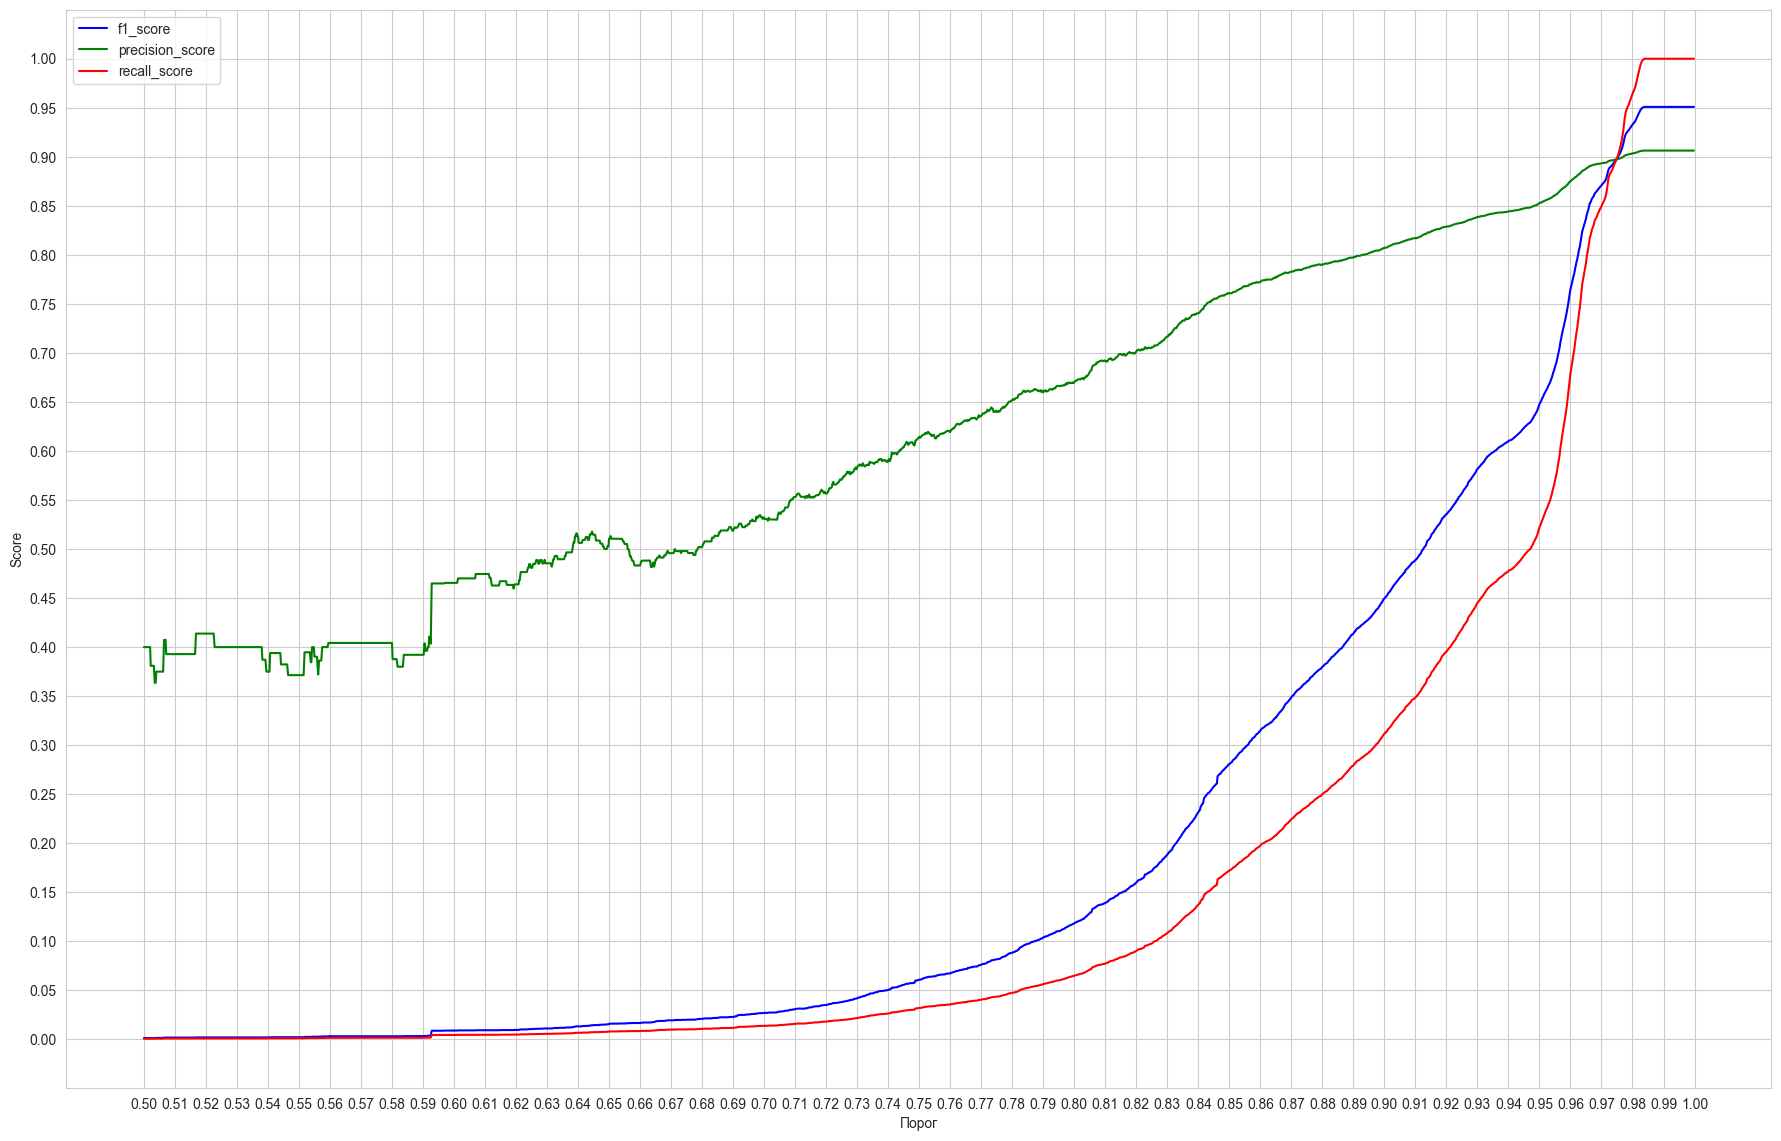

In [446]:
proba_threshold = [round(i, 4) for i in np.linspace(0.5, 1, num=2000, endpoint=False)]

# Создаем массивы порогов и результатов метрики f1
thresholds = []
f1_scores = []
precision_scores = []
recall_scores = []

# Изменяем порог
for i in proba_threshold:
    predictions['prediction'] = predictions['proba'].apply(lambda x: 1 if x < i else 0)

    thresholds.append(i)

    f1_scores.append(f1_score(predictions['actual'], predictions['prediction']))
    precision_scores.append(precision_score(predictions['actual'], predictions['prediction']))
    recall_scores.append(recall_score(predictions['actual'], predictions['prediction']))

fig, ax = plt.subplots(figsize=(22, 14))

sns.lineplot(x=thresholds, y=f1_scores,
             legend=True, label='f1_score',
             color='blue', ax=ax)
sns.lineplot(x=thresholds, y=precision_scores,
             label='precision_score',
             color='green', ax=ax)
sns.lineplot(x=thresholds, y=recall_scores,
             label='recall_score',
             color='red', ax=ax)

ax.set_ylabel('Score')
ax.set_yticks(np.arange(0, 1.01, 0.05))

ax.set_xlabel('Порог')
ax.set_xticks(np.arange(0.5, 1.01, 0.01))

plt.show()
# plt.title('Зависимость потерь в млн рублей от выбранного порога');

### Вывод:

После применения RandomizedSearchCV лучшей моделью оказалась `XGBClassifier`, со следующими параметрами:
- `preprocessor__num`: 'passthrough',
- `subsample`: 0.8,
- `reg_lambda`: 1,
- `reg_alpha`: 0.1,
- `n_estimators`: 200,
- `max_depth`: 6,
- `learning_rate`: 0.01,
- `colsample_bytree`: 0.8,

Точность метрики `f1_score` составила `0.951` на тренировочной и валидационной выборках. Метрика отличается на 0.0001, что говорит о том, что модель хорошо обучилась

## Предсказания модели

In [495]:
test_df_processed

,funding_total_usd,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,last_funding_at_year
0,2819200.0,other,other,other,other,1,Travel,2009,2009
1,2000000.0,USA,TN,other,other,1,Manufacturing,2010,2010
2,428257.0,other,other,other,other,2,biotechnology,2014,2014
3,34700000.0,USA,CA,San Diego,San Diego,4,Healthcare,2005,2010
4,4530000.0,CAN,ON,other,other,1,Manufacturing,2007,2007
...,...,...,...,...,...,...,...,...,...
13120,28000.0,USA,CA,SF Bay Area,other,1,Finance,2012,2012
13121,2000000.0,USA,CA,SF Bay Area,Mountain View,1,Technology,2013,2013
13122,5600000.0,USA,WA,Seattle,Seattle,3,hardware + software,2008,2011
13123,150000.0,USA,NY,New York City,New York,2,E-Commerce,2014,2014


In [496]:
X_test = test_df_processed
X_test

,funding_total_usd,country_code,state_code,region,city,funding_rounds,global_category,first_funding_at_year,last_funding_at_year
0,2819200.0,other,other,other,other,1,Travel,2009,2009
1,2000000.0,USA,TN,other,other,1,Manufacturing,2010,2010
2,428257.0,other,other,other,other,2,biotechnology,2014,2014
3,34700000.0,USA,CA,San Diego,San Diego,4,Healthcare,2005,2010
4,4530000.0,CAN,ON,other,other,1,Manufacturing,2007,2007
...,...,...,...,...,...,...,...,...,...
13120,28000.0,USA,CA,SF Bay Area,other,1,Finance,2012,2012
13121,2000000.0,USA,CA,SF Bay Area,Mountain View,1,Technology,2013,2013
13122,5600000.0,USA,WA,Seattle,Seattle,3,hardware + software,2008,2011
13123,150000.0,USA,NY,New York City,New York,2,E-Commerce,2014,2014


In [497]:
# # Проверка для колонки 'category_list'
# train_categories = X_train['category_list'].unique()
# test_categories = X_test['category_list'].unique()
#
# new_categories = set(test_categories) - set(train_categories)
# print(f"Новые категории в тесте: {new_categories}")

In [498]:
submission = pd.DataFrame({
    'name': test_df['name'],
    'proba': rs.best_estimator_.predict_proba(X_test)[:, 1]
})

submission

/Users/moncervers/PycharmProjects/startup_closure_prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,name,proba
0,Crystalsol,0.868911
1,JBI Fish & Wings,0.901151
2,COINPLUS,0.967084
3,Imagine Communications,0.885794
4,DNA13,0.842709
...,...,...
13120,Jymob,0.863871
13121,GlobaTrek,0.949425
13122,Inkd.com,0.891169
13123,AdWill,0.971630


In [499]:
submission['status'] = submission['proba'].apply(lambda x: 'operating' if x > 0.95 else 'closed')
submission = submission[['name', 'status']]
submission

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,closed
2,COINPLUS,operating
3,Imagine Communications,closed
4,DNA13,closed
...,...,...
13120,Jymob,closed
13121,GlobaTrek,closed
13122,Inkd.com,closed
13123,AdWill,operating


In [500]:
submission.to_csv('submission.csv', index=False)